In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
import tensorflow_datasets as tfds

ds = tfds.load("eurosat/rgb", split="train[:10%]", shuffle_files=True, as_supervised=True)

label_names = tfds.builder("eurosat/rgb").info.features["label"].names
print("\nLabel names:", label_names)


Label names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


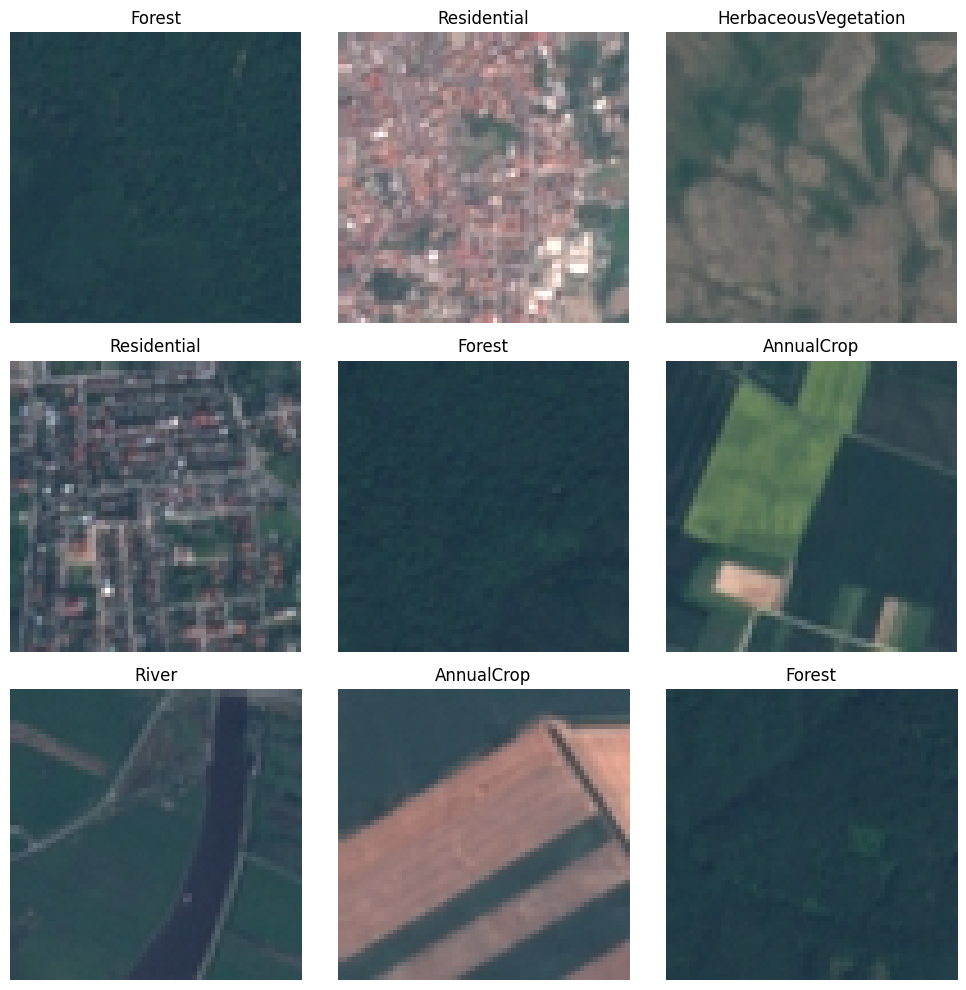

In [ ]:
#View a sample of the dataset in use

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds.take(9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(label_names[int(label)])
    plt.axis("off")

plt.tight_layout()
plt.show()

**Question 1) Apply PCA and Report how many components do you need to preserve
95% of the variance?**

In [ ]:
#Preprocess the data
X_data=[]
Y_label=[]


IMG_SIZE=64
image_shapes=[]
for i,(img,label) in enumerate(tfds.as_numpy(ds)):
  shape=img.shape
  if shape[:2] != (IMG_SIZE, IMG_SIZE):
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)).numpy()
  else:
        img = img.astype(np.float32)


  img=img/255.0
  X_data.append(img)
  Y_label.append(label)

X_data=np.array(X_data)
Y_label=np.array(Y_label)

print(X_data.shape)
print(Y_label.shape)


(2700, 64, 64, 3)
(2700,)


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(Y_label), y=Y_label)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("\nClass weights:", class_weight_dict)


Class weights: {0: np.float64(0.8653846153846154), 1: np.float64(0.903010033444816), 2: np.float64(0.8823529411764706), 3: np.float64(0.9818181818181818), 4: np.float64(1.0546875), 5: np.float64(1.6981132075471699), 6: np.float64(1.0227272727272727), 7: np.float64(0.8940397350993378), 8: np.float64(1.148936170212766), 9: np.float64(0.9246575342465754)}


In [ ]:
#Flatten the dataset
X_flat_data=X_data.reshape(X_data.shape[0],-1)
print(X_flat_data.shape)

(2700, 12288)


In [ ]:
from sklearn.decomposition import PCA

pca_for_img=PCA(n_components=0.95)
X_after_pca=pca_for_img.fit_transform(X_flat_data)
cumm_var=np.cumsum(pca_for_img.explained_variance_ratio_)
number_of_comp = np.argmax(cumm_var >= 0.95) + 1

print(f"Number of components needed to preserve 95% of the variance: {number_of_comp}")

Number of components needed to preserve 95% of the variance: 245


As we can see from the results, after applying PCA the number of components needed to preserve 95% of the variance is 245.

**Question 2) Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 90% of variance using PCA.**

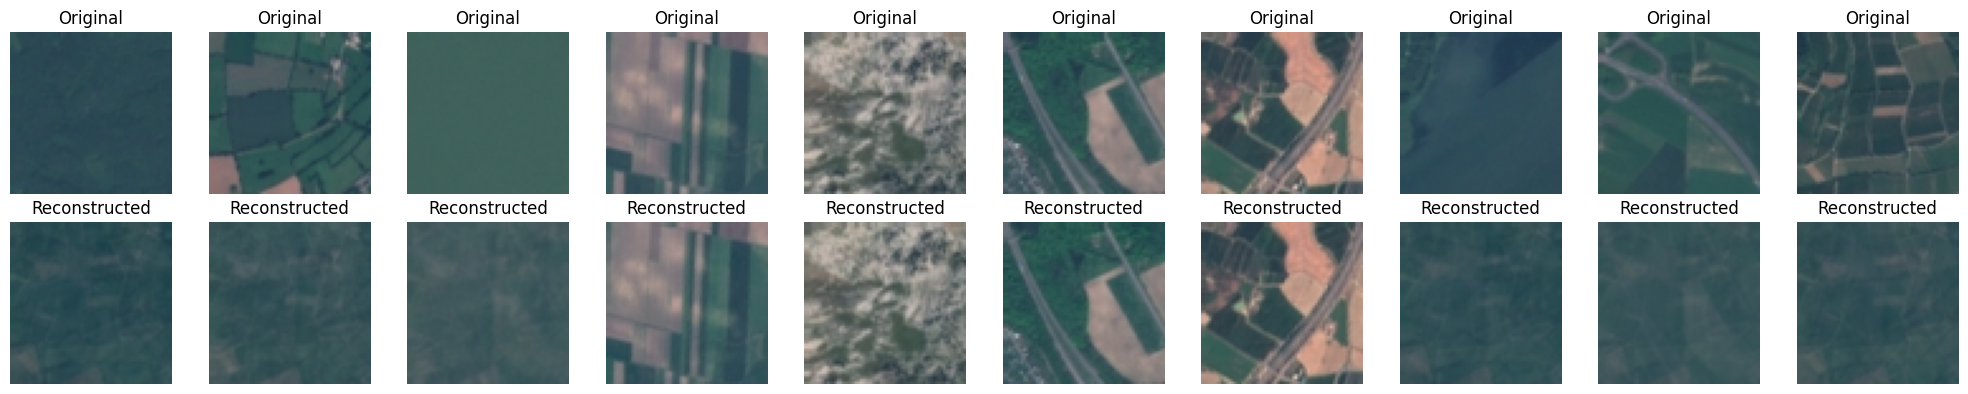

In [ ]:
random_choice=np.random.choice(len(X_flat_data), 10, replace=False)
X_chosen_data=X_flat_data[random_choice]

#Perserve 90% of the variance and use the inverse_transform to reconstruct the images
pca_90=PCA(n_components=0.90)
reduced_data=pca_90.fit_transform(X_chosen_data)
reconstructed_data=pca_90.inverse_transform(reduced_data)

#Plot the original and the reconstructed images side by side
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_chosen_data[i].reshape(64, 64, 3))
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(np.clip(reconstructed_data[i].reshape(64, 64, 3), 0, 1))  # Clip for display
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


From the results we can observe that, Almost all reconstrcuted images retain the general layout and major regions, colors in the images demonstrating its effectiveness in compressing high-dimensional image data. So we can see that 90% variance can capture most of the information.

**Question 3A) Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?**

After applying PCA to reduce the dimensionality of the EuroSAT dataset to just 2 principal components, we observed the following:

* Variance explained by 1st component: 64.13%

* Variance explained by 2nd component: 2.59%

* Total variance explained by the first two components: 66.72%

In [ ]:
#Reducing to only 2 dimensions
pca_2=PCA(n_components=2)
X_2d_data=pca_2.fit_transform(X_flat_data)

#Variance of first 2 components
explained_variance = pca_2.explained_variance_ratio_
print(f"Variance of first two components: {explained_variance[:2]}")

print(f"Variance explained by the first two components: {explained_variance.sum():.4f}")

Variance of first two components: [0.64133286 0.0258982 ]
Variance explained by the first two components: 0.6672


This means that the first 2 principal components together capture about 66.7% of the total information. he first component alone captures the majority of the structure. The second adds a little more, but there's still about 33% of variance left in the remaining components.

**3B. Scatter Plots of Components with some Images from the dataset a) t-SNE (2) b) LLE (2) c) MDS**

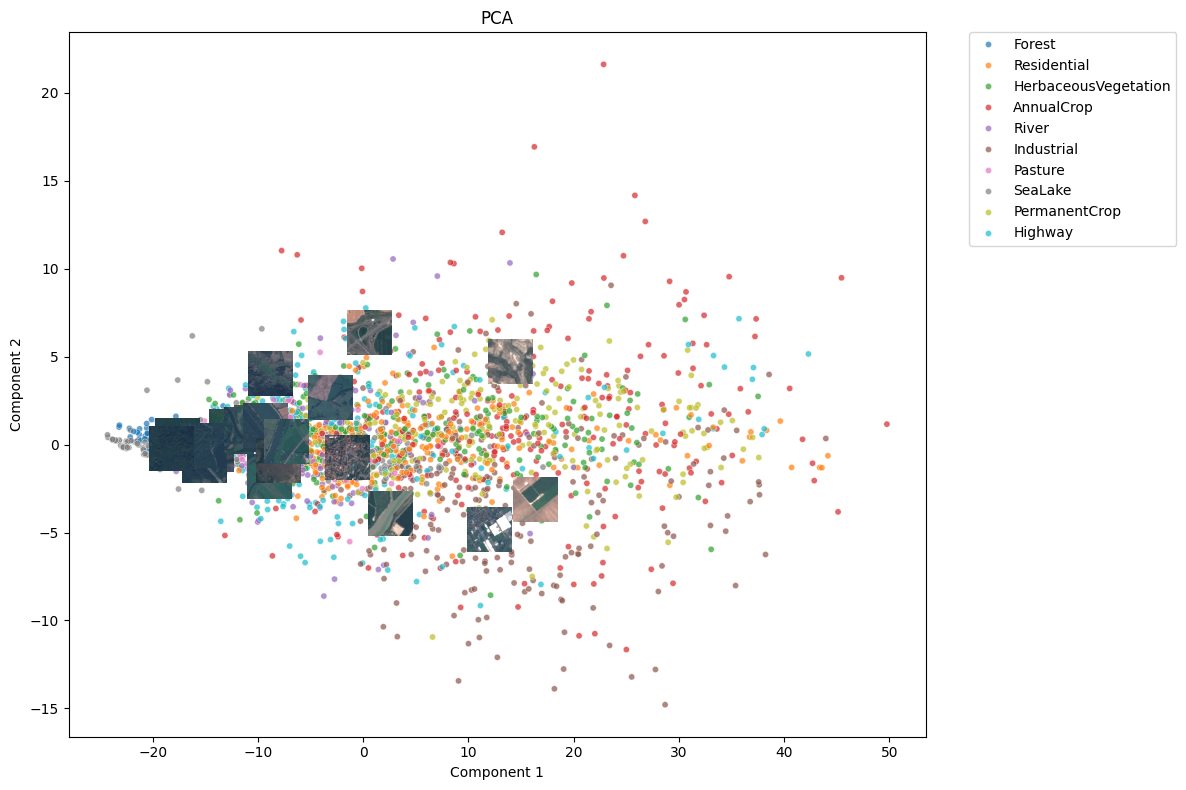

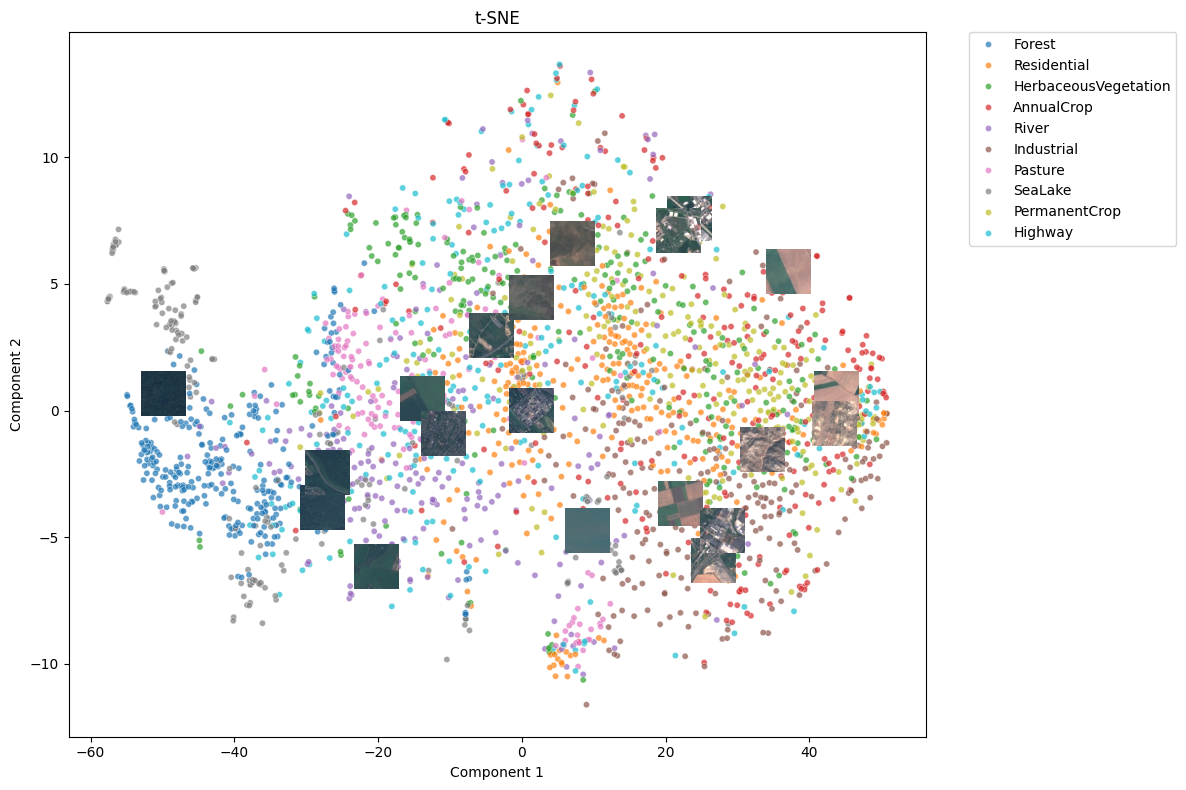

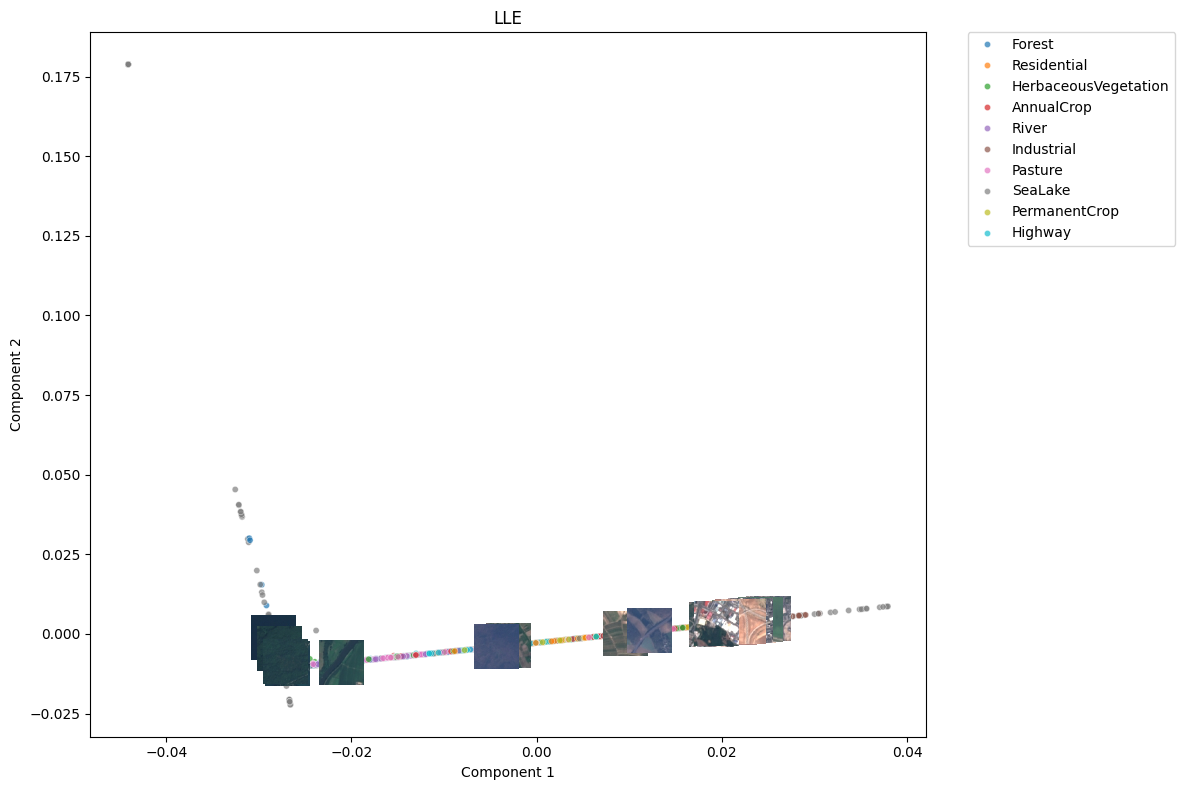

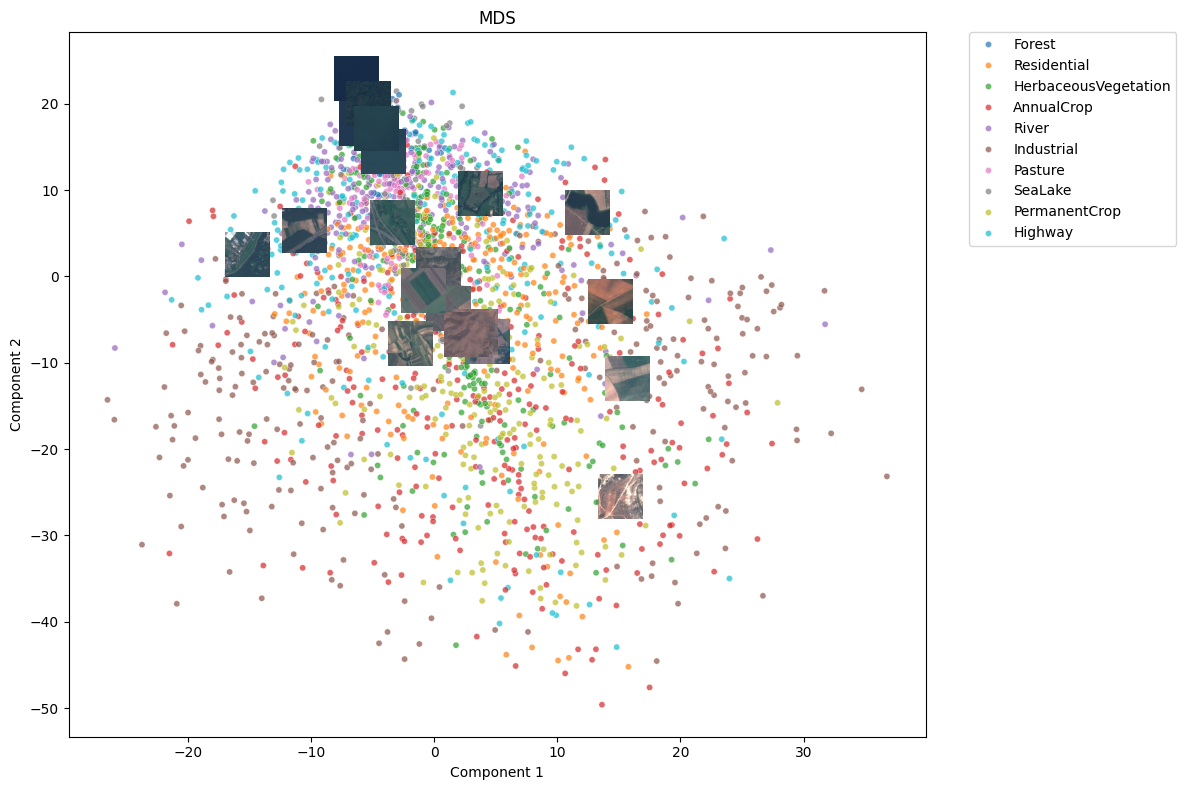

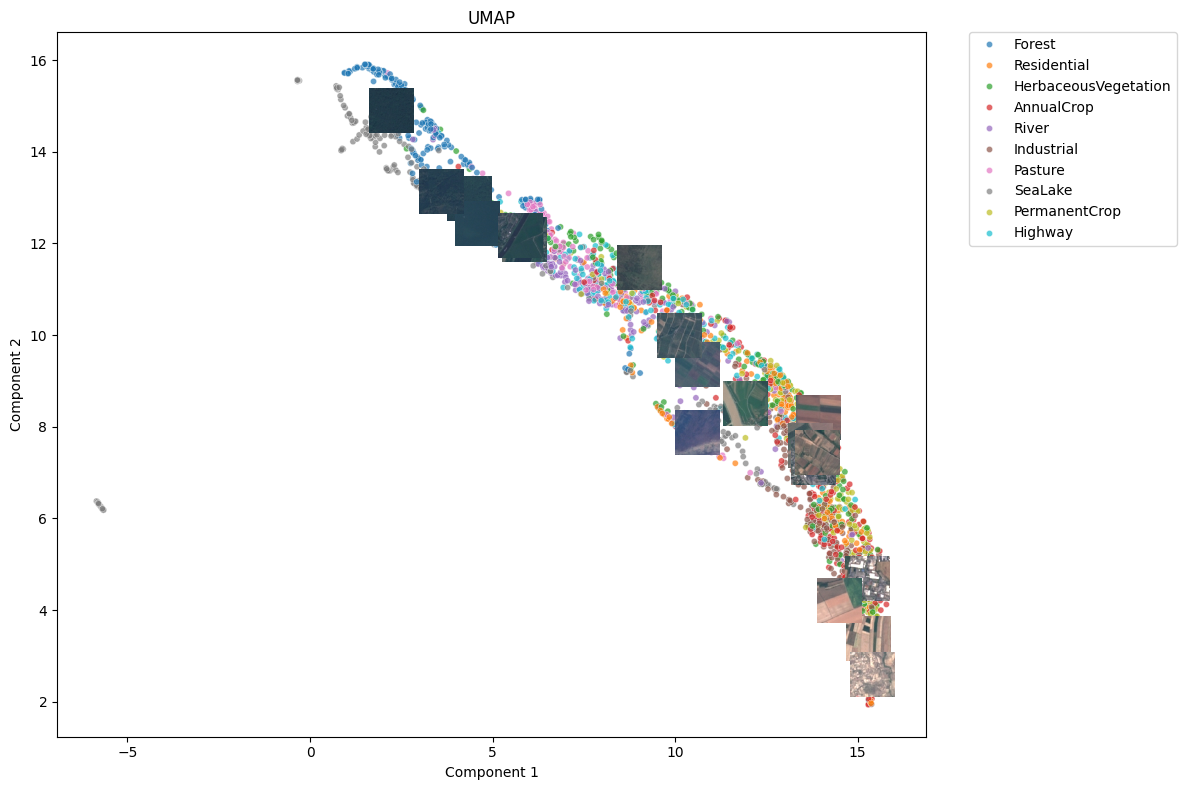

In [ ]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap.umap_ as umap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# Function to apply dimensionality reduction
def apply_dim_reduction(method, X):
    if method == "PCA":
        function = PCA(n_components=2)
    elif method == "t-SNE":
        function = TSNE(n_components=2, random_state=42, perplexity=30)
    elif method == "LLE":
        function = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
    elif method == "MDS":
        function = MDS(n_components=2, random_state=42, n_init=1, max_iter=300)
    elif method == "UMAP":
        function = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Unsupported method")
    return function.fit_transform(X)

# Function to plot with thumbnails
def plot_with_images(X_2d, images, labels, label_names, title):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(111)

    sns.scatterplot(
        x=X_2d[:, 0], y=X_2d[:, 1],
        hue=[label_names[i] for i in labels],
        palette='tab10', alpha=0.7, s=20
    )

    for idx in np.random.choice(len(X_2d), 20, replace=False):
        img = images[idx]
        imagebox = OffsetImage(img, zoom=0.5)
        ab = AnnotationBbox(imagebox, (X_2d[idx, 0], X_2d[idx, 1]), frameon=False)
        ax.add_artist(ab)

    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# Apply and plot each method
methods = ["PCA", "t-SNE", "LLE", "MDS", "UMAP"]
for method in methods:
    X_2d = apply_dim_reduction(method, X_flat_data)
    plot_with_images(X_2d, X_data, Y_label, label_names, f"{method}")


**3C. Discuss the observations from above**

From the above vizualizations, we can see that

* PCA shows a clear linear spread and provides a reasonably good separation between several classes in 2D. While it captures the dominant structure in the data, it does not fully represent the nonlinear complexity of all image categories. Still, we observe that images with similar color tones, textures, and terrain patterns tend to cluster together. This indicates that PCA is effectively capturing major sources of variance in the satellite imagery, even though some class overlap remains due to its linear nature.

* The t-SNE 2D representation shows a well-separated cluster of images, capturing the nonlinear structure of the data better than PCA. It produces distinct clusters that align closely with image categories.

* The LLE projection shows the underlying manifold structure of the image data by preserving local relationships between neighboring samples.The visualization reveals clusters of similar-looking images, especially where subtle texture or terrain transitions occur. The thumbnails embedded in the projection space confirm that LLE retains fine-grained visual similarities between nearby points.

* MDS focuses on preserving the pairwise distances between images in the high-dimensional space. The 2D projection shown above does not form well-separated clusters, but instead presents a spread of points that reflects relative similarities.  Overall, MDS provides a useful global view, but lacks the strong local grouping that other nonlinear techniques offer.

* UMAP captures the local and gobal structure of the data well.The shape of the projection usually follows a curved manifolds, which aligns with how image data is organized in high-dimensional space. Image thumbnails clearly show that UMAP places visually and semantically similar images together, making it highly effective for understanding feature-driven variance.



**Question 4) Cluster the images using K-Means.
You can reduce the dimensionality using PCA if you wish, but keep at least 95% of the variance. Determine the number of clusters using one of the techniques we discussed in class.
Set the number of clusters to 3, report clustering accuracy and show a confusion matrix.
Visualize the figures from question 3B again, but this time, color the clusters based on your algorithm's output (it's enough to use only one method - either PCA, t-SNE, LLE or UMAP)**




In [ ]:
#Apply PCA preserve 95% of the variance (already done this above)

print(f"Original data shape: {X_flat_data.shape}")
print(f"After applying PCA: {X_after_pca.shape}")


Original data shape: (2700, 12288)
After applying PCA: (2700, 245)


* We originally had You have 2,700 images, each flattened from 64×64×3 = 12,288 pixels
* Now we have, 245 components that preserve 95% of the variance.

K=2, Silhouette Score = 0.4081
K=3, Silhouette Score = 0.3007
K=4, Silhouette Score = 0.2505
K=5, Silhouette Score = 0.1993
K=6, Silhouette Score = 0.1610
K=7, Silhouette Score = 0.1385
K=8, Silhouette Score = 0.1342
K=9, Silhouette Score = 0.1268
K=10, Silhouette Score = 0.1248


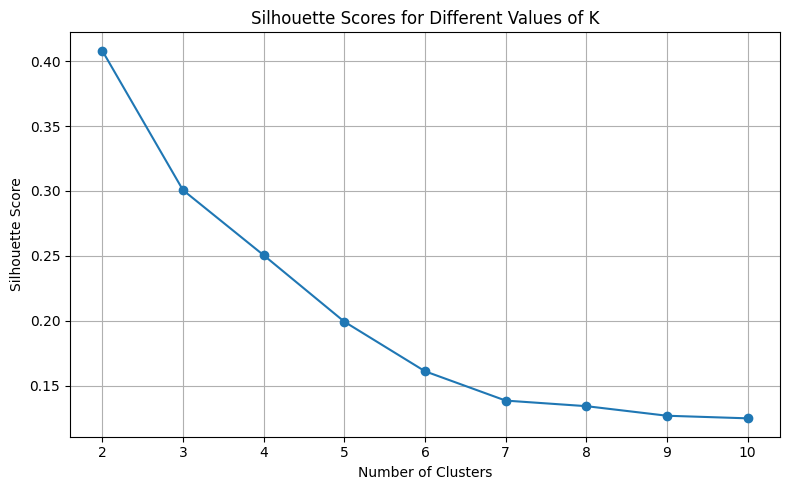

In [ ]:
#The silhouette score tells us how well each point lies within its cluster
#We will now determine the number of clusters by calculating the silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silo_scores=[]
k_values=range(2,11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_after_pca)
    score = silhouette_score(X_after_pca, labels)
    silo_scores.append(score)
    print(f"K={k}, Silhouette Score = {score:.4f}")

#Plot the scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silo_scores, marker='o')
plt.title("Silhouette Scores for Different Values of K")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()


By calculating the Silhouette scores for K values between 2 to 10 we can see that the maximum value of Silhouette Score can be seen as 0.4081 for K=2. The Silhoutte Score drops to 0.30 for K=3. After K = 3, scores drop sharply, suggesting no real improvement with higher K.



K=2, Inertia = 436856.3750
K=3, Inertia = 344909.0312
K=4, Inertia = 307341.5312
K=5, Inertia = 290584.0625
K=6, Inertia = 281057.0000
K=7, Inertia = 274327.2500
K=8, Inertia = 270781.1250
K=9, Inertia = 266615.5000
K=10, Inertia = 263925.3750


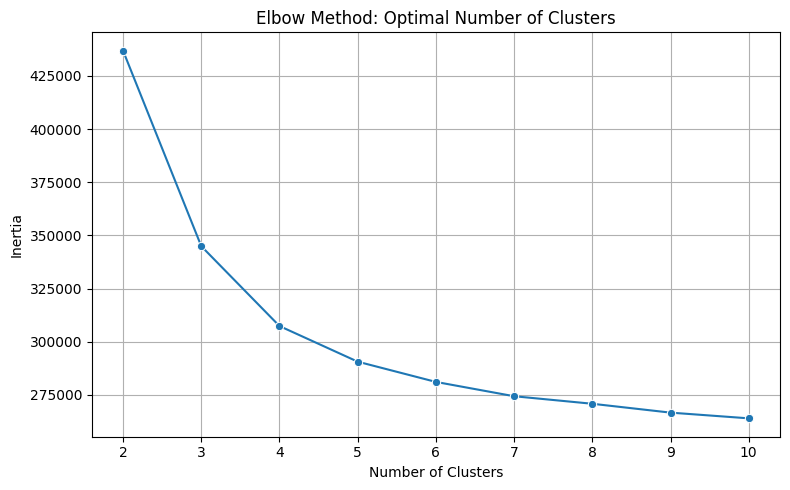

In [ ]:
#Calculate interia for different values of k
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(k, random_state=42)
    kmeans.fit(X_after_pca)
    inertia.append(kmeans.inertia_)
    print(f"K={k}, Inertia = {inertia[-1]:.4f}")

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(k_range), y=inertia, marker='o')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.tight_layout()
plt.show()

From the Elbow Method Reprsentation, we observe that the Inertia value drops sharply from K=2 to K=3, then it slowly decreases. After K = 3, the curve begins to flatten. The elbow point is at K=3.


Based on both the evaluation methods, K=3 is the most appropriate number of clusters. Now lets compute clustering accuracy and draw out the confusion matrix


Confusion matrix before remapping:
[[131 155  26   0   0   0   0   0   0   0]
 [  0   0 299   0   0   0   0   0   0   0]
 [152  61  93   0   0   0   0   0   0   0]
 [118  26 131   0   0   0   0   0   0   0]
 [137 118   1   0   0   0   0   0   0   0]
 [ 44   0 115   0   0   0   0   0   0   0]
 [134 104  26   0   0   0   0   0   0   0]
 [227  46  29   0   0   0   0   0   0   0]
 [ 80   6 149   0   0   0   0   0   0   0]
 [ 75   1 216   0   0   0   0   0   0   0]]

Clustering accuracy after label mapping: 25.22%

Confusion matrix after remapping:
[[155  26   0   0   0   0   0 131   0   0]
 [  0 299   0   0   0   0   0   0   0   0]
 [ 61  93   0   0   0   0   0 152   0   0]
 [ 26 131   0   0   0   0   0 118   0   0]
 [118   1   0   0   0   0   0 137   0   0]
 [  0 115   0   0   0   0   0  44   0   0]
 [104  26   0   0   0   0   0 134   0   0]
 [ 46  29   0   0   0   0   0 227   0   0]
 [  6 149   0   0   0   0   0  80   0   0]
 [  1 216   0   0   0   0   0  75   0   0]]


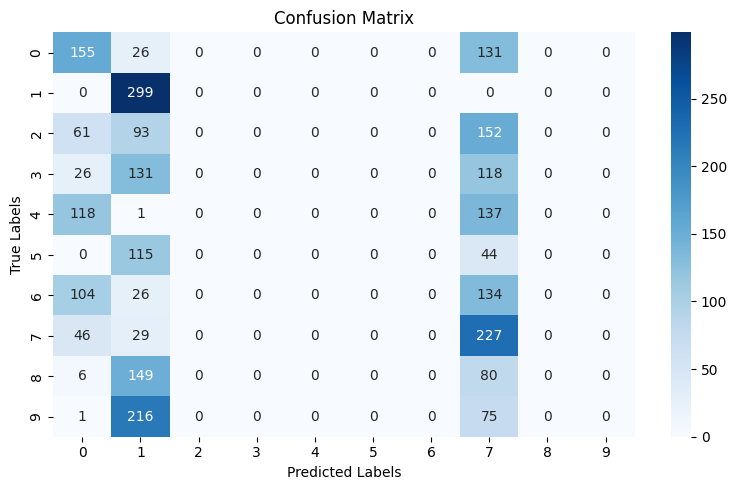

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import matplotlib.pyplot as plt


#KMeans with 3 clusters on PCA-reduced data
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_predicted_labels = kmeans.fit_predict(X_after_pca)

#Confusion Matrix against True Labels and Predicted CLusters
conf_matrix = confusion_matrix(Y_label, kmeans_predicted_labels)
print("\nConfusion matrix before remapping:")
print(conf_matrix)

# Match cluster numbers to real labels using Hungarian method
row_index, column_index = linear_sum_assignment(-conf_matrix)
label_dict= dict(zip(column_index, row_index))

# Step 4: Apply the label mapping to all predicted labels
mapped_predictions = np.array([label_dict[label] for label in kmeans_predicted_labels])

accuracy = accuracy_score(Y_label, mapped_predictions)
print(f"\nClustering accuracy after label mapping: {accuracy * 100:.2f}%")

# Calculate new confusion matrix
new_conf_matrix = confusion_matrix(Y_label, mapped_predictions)
print("\nConfusion matrix after remapping:")
print(new_conf_matrix)

plt.figure(figsize=(8, 5))
sns.heatmap(new_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

After applying KMeans clustering with K = 3 on PCA-reduced EuroSAT data. To better evaluate performance, we matched predicted cluster labels to true labels using the Hungarian algorithm, which optimally remaps cluster indices to maximize correct matches.

The resulting confusion matrix showed moderate alignment between predicted clusters and actual land cover classes, achieving an overall clustering accuracy of 25.22%. This is reasonable as its challenging to compress 10 categories into only 3 clusters. There were certain categories, like class 1 and class 7, which formed more coherent clusters, while others were more mixed across cluster boundaries.

**4C. Visualize the figures from question 3B again, but this time, color the clusters based on your algorithm's output (it's enough to use only one method - either PCA, t-SNE, LLE or UMAP)**


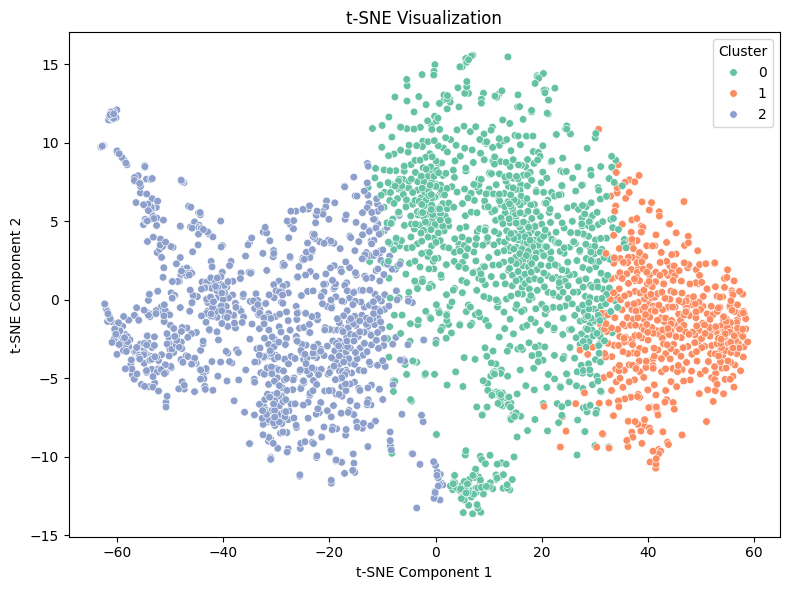

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_after_pca)

#K Means was calculated above we will reuse the same variables
#Plot the 2D scatter plot with colors based on clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans_predicted_labels, palette='Set2', s=30)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


The figure above shows the 2D t-SNE projection of PCA-reduced image data, with each point representing an image and colored by its assigned KMeans cluster (K=3). We observe that the KMeans algorithm was able to identify three distinct regions in the data, with good separation between clusters. While there is some overlap, each cluster tends to group together in specific regions of the projection space, suggesting that the algorithm captured underlying structure in the image features.

**Question 5A) Clustering using EM(Gaussian Mixture Model). Also, Determine K**

Answer) For Part 5, The question implements EM algorithm via Gaussian Mixture Models (GMM) to cluster PCA-reduced EuroSAT images into 3 groups. After matching predicted clusters to true labels, we achieved an accuracy of 20.52% and visualized the clustering using t-SNE. Additionally, Sampled 20 new data points from the GMM model and reconstructed them into image space using the inverse PCA transform. The generated images reflected common patterns learned by the model.

Optimal No. of Clusters for EM (GMM): 2


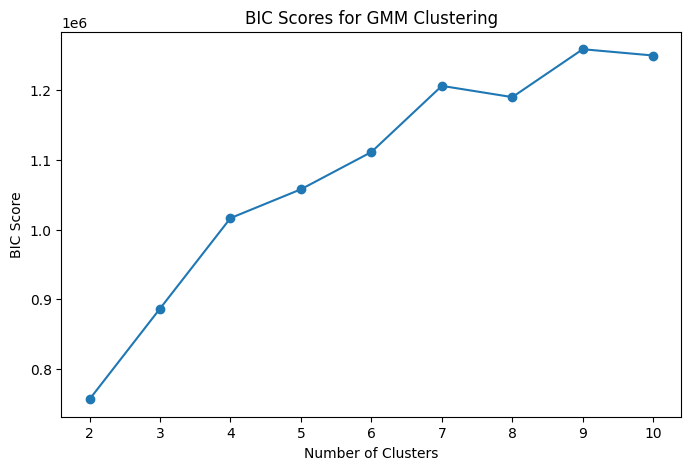

In [ ]:
#Apply PCA to Preserve 95% of the variance, already done this above
#Next step to find the optimal K value using BIC

from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
n_components = list(range(2, 11))

bic_scores = []
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_after_pca)
    bic_scores.append(gmm.bic(X_after_pca))

optimal_k = n_components[np.argmin(bic_scores)]
print(f"Optimal No. of Clusters for EM (GMM): {optimal_k}")

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), bic_scores, marker='o')
plt.title("BIC Scores for GMM Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score")
plt.show()



**Question 5B) Calculate the Clustering Accuracy and Plot the Confusion Matrix**

Clustering Accuracy: 20.52%


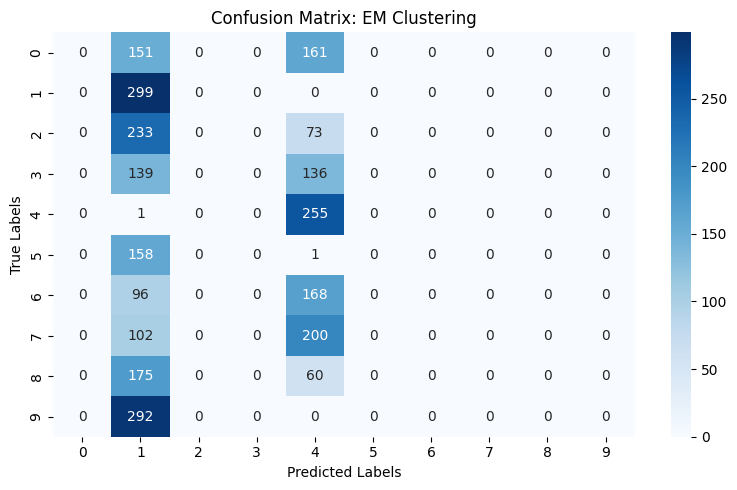

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm.fit(X_after_pca)
pred_labels = gmm.predict(X_after_pca)

conf_matrix_em = confusion_matrix(Y_label, pred_labels)
row_ind, col_ind = linear_sum_assignment(-conf_matrix_em)
label_map_em = dict(zip(col_ind, row_ind))

em_mapped = np.array([label_map_em[label] for label in pred_labels])

# Accuracy and confusion matrix
accuracy_em = accuracy_score(Y_label, em_mapped)
print(f"Clustering Accuracy: {accuracy_em * 100:.2f}%")

final_em_matrix = confusion_matrix(Y_label, em_mapped)
plt.figure(figsize=(8, 5))
sns.heatmap(final_em_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: EM Clustering")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


**Question 5C) Vizualize using t-SNE, Colored by EM Clusters**

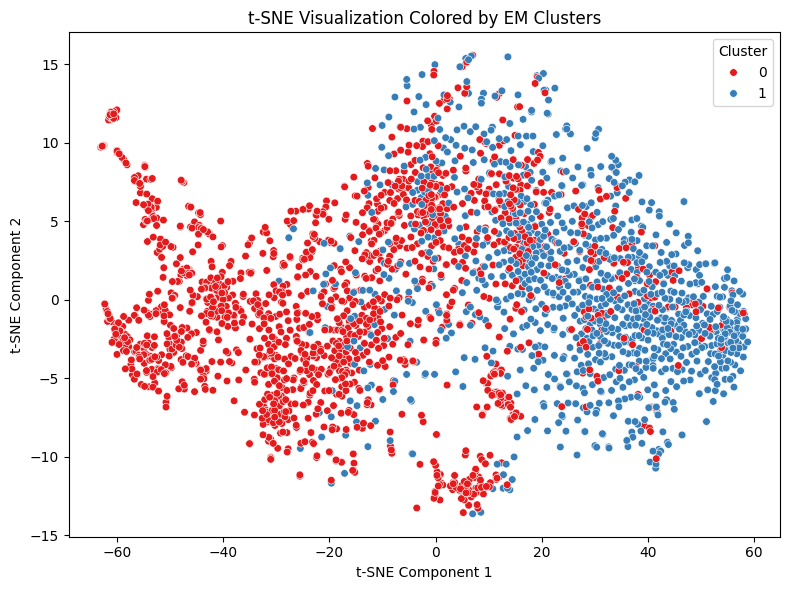

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_em = tsne.fit_transform(X_after_pca)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne_em[:, 0], y=X_tsne_em[:, 1], hue=pred_labels, palette='Set1', s=30)
plt.title("t-SNE Visualization Colored by EM Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


**Question 5D)Generate New Samples from EM and Reconstruct Original Images**

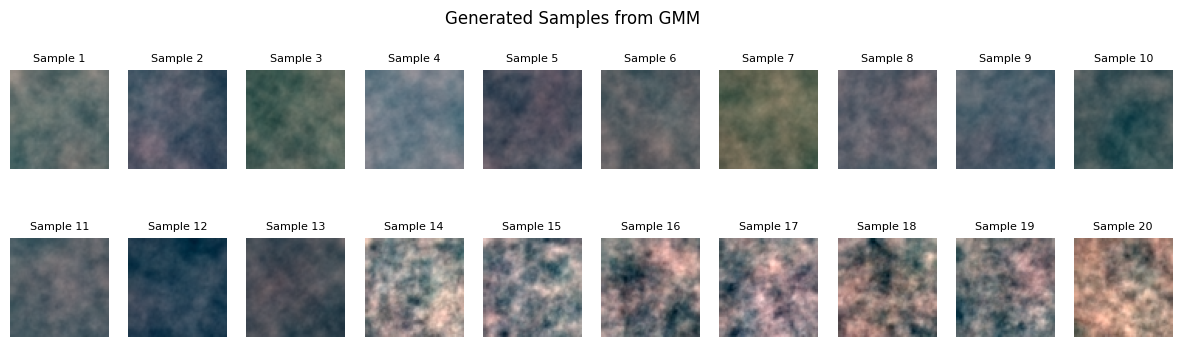

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Generate new samples
new_samples_pca, _ = gmm.sample(20)

# Inverse transform to original space
new_samples = pca_for_img.inverse_transform(new_samples_pca)

new_samples = new_samples.reshape(-1, 64, 64, 3)


# Reshape and plot
plt.figure(figsize=(15, 4))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(new_samples[i].reshape(64, 64, 3))
    plt.axis('off')
    plt.title(f"Sample {i+1}", fontsize=8)
plt.suptitle('Generated Samples from GMM')
plt.show()


By sampling 20 images, fitted GMM using the sample() method and using inverse PCA transformation to reconstruct them into image space. The images reflect blurred, yet realistic satellite textures representative of the EuroSAT dataset. Some pixel values exceeded the valid RGB range and were clipped to ensure proper rendering.

**Question 6A) Build and Train a Feedforward Neural Network using Keras**

Answer) To start builiding the Feedforward Neural Network we start a dense neural network using Keras to classify EuroSAT images into 10 land cover categories. Started by splitting the training, validation data samples from the X_data. Keeping the split as Training Data is 80% and Test Size as 20%.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(
    X_data, Y_label,
    test_size=0.2,
    random_state=42,
    stratify=Y_label
)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
val_generator = train_datagen.flow(
    X_val, y_val, batch_size=16, shuffle=False
)


To improve generalization and reduce overfitting, real-time data augmentation was applied to the training images using Keras ImageDataGenerator. The following transformations were used:

Rotation: Random rotations up to 10 degrees.

Zoom: Random zoom within a 10% range.

Horizontal Flip: Randomly flipped images horizontally.

Fill Mode: 'nearest' was used to fill in any empty pixels after transformation.

The validation data was not augmented to ensure consistent evaluation. Both training and validation datasets were processed in batches of 16. The training generator is applied to these augmentations on-the-fly during training, while the validation generator is provided a fixed dataset for evaluation.

This augmentation strategy helped the model generalize better by exposing it to varied spatial representations of the same classes without significantly increasing training time or memory usage.

**Question 6B) Build and Train the Neural Network**

Answer) For this task, we designed a Convolutional Neural Network (CNN) was implemented using the Keras Sequential API to classify EuroSAT land cover images.

Conv Block 1: A 3×3 convolutional layer with 16 filters, followed by batch normalization, ReLU activation, 2×2 max pooling, and 20% dropout.

Conv Block 2: A 3×3 convolutional layer with 32 filters, followed by batch normalization, ReLU activation, 2×2 max pooling, and 30% dropout.

Global Max Pooling: To flatten spatial dimensions.

Dense Layers:
A dense layer with 64 neurons and ReLU activation (L2 regularized), followed by 40% dropout.

An output layer with softmax activation for classifying into 10 land cover categories.
The model was compiled using the Adam optimizer with a learning rate of 0.0001, and sparse categorical cross-entropy as the loss function.
Training was performed for up to 60 epochs on augmented batches using ImageDataGenerator.

After training, the model was evaluated on the validation set. With Validation Accuracy of 55.55% and Validation Loss of 1.36

The  Training time taken by this model was approximately 206 seconds.



In [ ]:
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

from keras import backend as K
import gc

K.clear_session()
gc.collect()


def build_sequential_model(input_shape=(64, 64, 3), num_classes=10):

    model = models.Sequential()
    #Block 1
    model.add(layers.Conv2D(16, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    # Block 2
    model.add(layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.GlobalMaxPooling2D())
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


model = build_sequential_model()

optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)
early_stop = callbacks.EarlyStopping(patience=7, restore_best_weights=True)



# Train the model and measure training time
start_time = time.time()

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),
    epochs=60,
    validation_data=val_datagen.flow(X_val, y_val, batch_size=30),
    callbacks=[lr_schedule, tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

end_time = time.time()
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
print(f"\n Training Time: {end_time - start_time} seconds")



Epoch 1/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.1103 - loss: 7.5255 - val_accuracy: 0.1407 - val_loss: 2.3193 - learning_rate: 1.0000e-04
Epoch 2/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.1399 - loss: 4.0633 - val_accuracy: 0.2204 - val_loss: 2.2351 - learning_rate: 1.0000e-04
Epoch 3/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.1683 - loss: 3.1751 - val_accuracy: 0.3407 - val_loss: 2.1371 - learning_rate: 1.0000e-04
Epoch 4/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.2198 - loss: 2.7100 - val_accuracy: 0.3519 - val_loss: 2.0633 - learning_rate: 1.0000e-04
Epoch 5/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.2103 - loss: 2.5328 - val_accuracy: 0.3574 - val_loss: 2.0163 - learning_rate: 1.0000e-04
Epoch 6/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2321 - loss: 2.3454 - val_accuracy: 0.3667 - val_loss: 1.9852 - learning_rate: 1.0000e-04
Epoch 7/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - acc

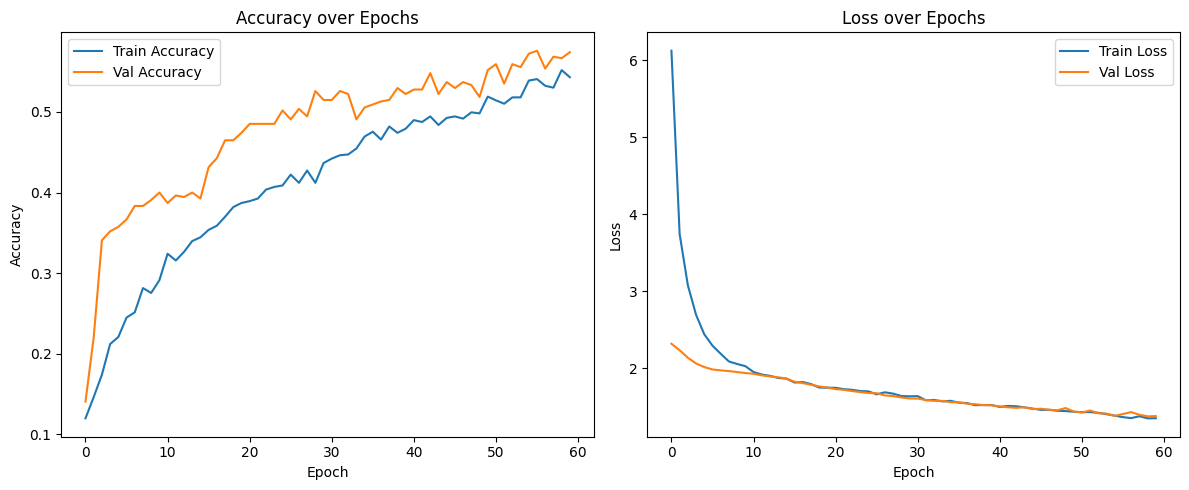

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


The plots above show the trends in accuracy and loss over epochs, In the accuracy plot (left), we observe that the training accuracy gradually increases throughout the epochs, showing effective learning of features and the Validation accuracy consistently improves and surpasses training accuracy, peaking above 56%, indicating strong generalization to unseen data.

The upward trend in both curves demonstrates no overfitting, as validation performance does not decline.
The loss plot (right) depicts that the training and validation loss both decrease steadily and nearly in parallel. The convergence of both curves suggests a well-regularized model with balanced bias-variance trade-off.
The initial steep drop indicates fast early learning, while the later gradual decline shows fine-tuning as the learning rate reduces via the scheduler.

**Question 6C) How many parameters does the network have? How many of those parameters are bias parameters?**

Answer) As shown in the results, the Total Number of parameters are 23,936 and Out of which total No of Bias Paramters are 218.


In [ ]:
model.summary()

# Count total bias parameters (1D tensors)
total_biases = sum([w.shape[0] for w in model.trainable_weights if len(w.shape) == 1])
print(f"\nTotal bias parameters: {total_biases}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,936 (93.50 KB)

 Trainable params: 7,946 (31.04 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 15,894 (62.09 KB)


Total bias parameters: 218


**Question 6D) Repeat part 5 (except 5D) on activity from neurons in your first layer (closest to the input), some layer around the middle of the network, and the layer just before the output layer.
Note that in this case, the input to EM is the neural activity, not the image itself. Thus, the dimensionality of the input is determined by how many neurons you have in that particular layer.
 Do this process around the middle of the training and after you complete the training.
 Discuss the changes you observe in clustering across the network and throughout the training.**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

layer_names = ['re_lu', 'max_pooling2d_1', 'dense']  # early, mid, final layer names

# Build intermediate model
intermediate_model = Model(
    inputs=model.inputs,
    outputs=[model.get_layer(name).output for name in layer_names]
)

# Predict in batches
batch_size = 32
act_first, act_mid, act_final = [], [], []

for i in range(0, len(X_data), batch_size):
    batch = X_data[i:i + batch_size]
    a1, a2, a3 = intermediate_model.predict(batch, verbose=0)
    act_first.append(a1)
    act_mid.append(a2)
    act_final.append(a3)

act_first = np.concatenate(act_first)
act_mid = np.concatenate(act_mid)
act_final = np.concatenate(act_final)


In [ ]:
#Function to process each layer
def process_layer_for_em_clustering(activations, true_labels, layer_name):
    if len(activations.shape) > 2:
        activations = GlobalAveragePooling2D()(tf.convert_to_tensor(activations)).numpy()
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(activations)

    bic_scores = []
    for k in range(2, 11):
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(X_pca)
        bic_scores.append(gmm.bic(X_pca))
    optimal_k = np.argmin(bic_scores) + 2

    gmm = GaussianMixture(n_components=optimal_k, random_state=42)
    preds = gmm.fit_predict(X_pca)

    conf_matrix = confusion_matrix(true_labels, preds)
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)
    label_map = dict(zip(col_ind, row_ind))
    mapped_preds = np.array([label_map[p] for p in preds])
    acc = accuracy_score(true_labels, mapped_preds)

    print(f"[{layer_name}] Optimal Clusters: {optimal_k}, Clustering Accuracy: {acc * 100:.2f}%")

    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(true_labels, mapped_preds), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix ({layer_name})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Vizualize t-SNE in 2-D
    X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_pca)
    plt.figure(figsize=(7, 5))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=mapped_preds, cmap='tab10', s=10)
    plt.title(f"t-SNE on {layer_name} Activations (EM Clusters)")
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    return optimal_k, acc * 100

[Early (re_lu)] Optimal Clusters: 10, Clustering Accuracy: 33.52%


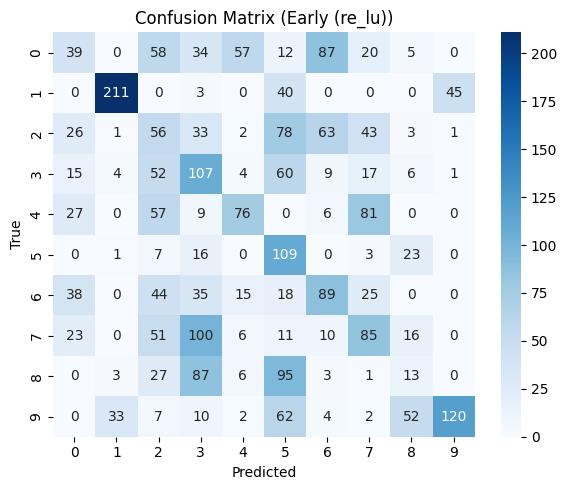

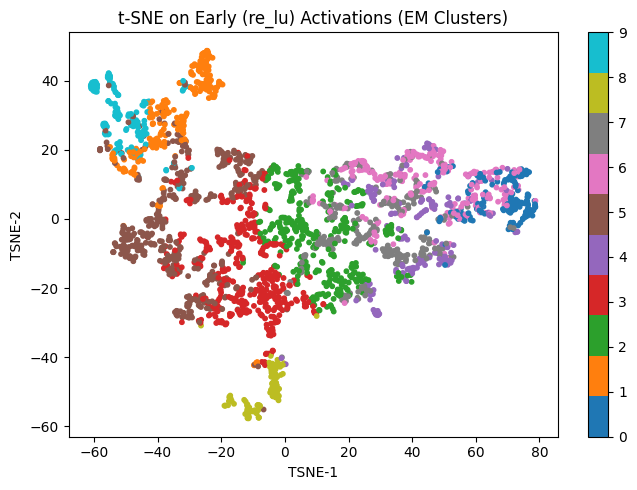

[Middle (max_pooling2d_1)] Optimal Clusters: 9, Clustering Accuracy: 38.00%


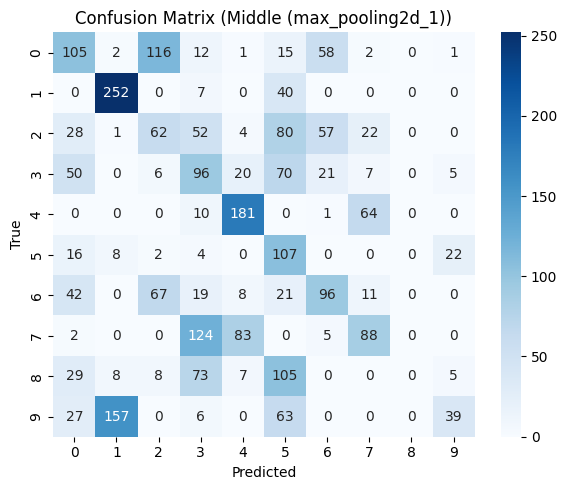

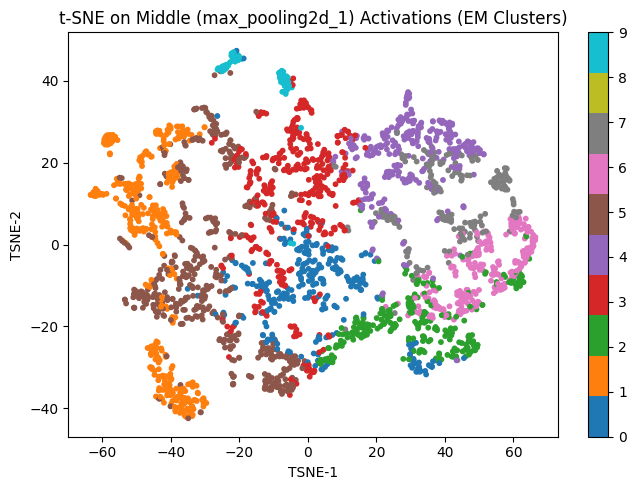

[Final (dense)] Optimal Clusters: 10, Clustering Accuracy: 50.04%


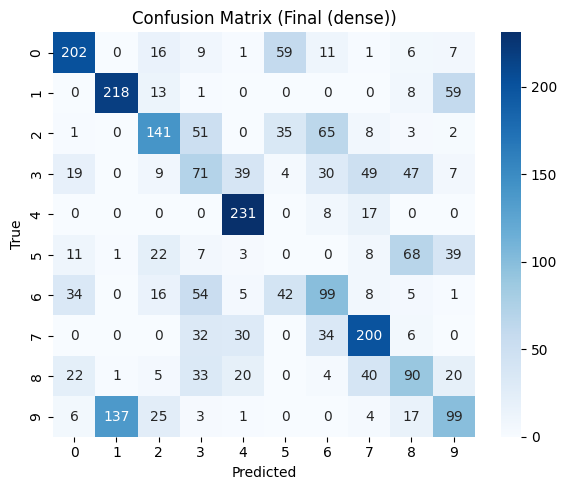

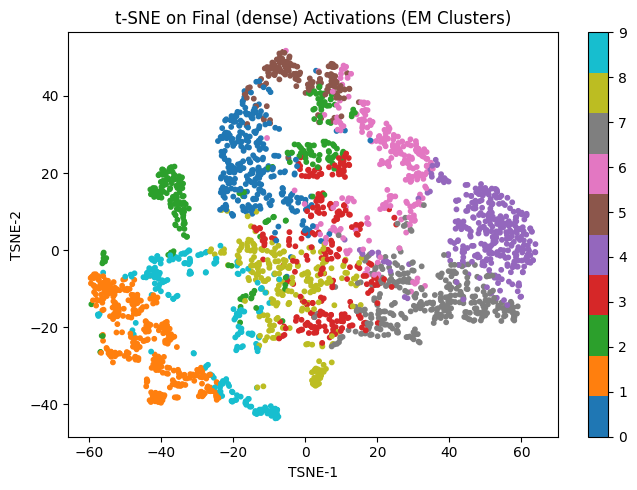

In [ ]:
## Run for all 3 layers
results = {}
results['early'] = process_layer_for_em_clustering(act_first, Y_label, "Early (re_lu)")
results['mid'] = process_layer_for_em_clustering(act_mid, Y_label, "Middle (max_pooling2d_1)")
results['final'] = process_layer_for_em_clustering(act_final, Y_label, "Final (dense)")

| Layer                   | Optimal Clusters | Clustering Accuracy |
|------------------------|------------------|---------------------|
| Early (re_lu)          | 10               | 33.52%              |
| Middle (max_pooling2d_1) | 9               | 38.00%              |
| Final (dense)          | 10                | 50.04%              |


* **Early Layer (re_lu):**
At this stage, activations primarily capture low-level features such as edges, colors, and textures. Clustering accuracy is relatively low (33.52%), indicating limited semantic separation among classes.

* **Middle Layer (max_pooling2d_1):**
The network begins to encode more complex structures and region-level patterns. Clustering improves to 38%, showing better—but still partial—discrimination among land cover types.

* **Final Layer (dense):**
Activations here reflect high-level, semantically rich features that correlate closely with class distinctions. Clustering accuracy rises significantly to 50.04%, indicating that the learned representations at this stage are far more class-discriminative—even in the absence of labels (unsupervised).